#Project:  Medical Disease Symptoms Analysis & Predictive Symptoms App  


# Introduction
This project aimed to analyze the relationship between weather conditions, patient health, and treatment outcomes. The goal was to build machine learning models that predict health outcomes based on weather data and patient conditions.

Additionally, an ongoing framework is in development to build an interactive app that allows users to input symptoms and receive predictions of possible diseases along with recommended treatments based on the dataset. This framework is designed to help provide quick, data-driven medical insights to users.

# Problem Statement
Patients' health can be affected by environmental factors such as weather conditions. Understanding these relationships could help improve treatment plans and hospital preparedness. The project involved analyzing a dataset of patients’ health conditions, weather variables, and treatment outcomes to build predictive models.

# About the data
User: includes an ID, age, sex, and country.

Condition: an illness or diagnosis, for example Rheumatoid Arthritis, rated on a scale of 0 (not active) to 4 (extremely active).

Symptom: self-explanatory, also rated on a 0–4 scale.

Treatment: anything a patient uses to improve their symptoms, along with an optional dose, which is a string that describes how much they took during the day. For instance “3 x 5mg”.

Tag: a string representing an environmental factor that does not occur every day, for example “ate dairy” or “rainy day”.

Food: food items were seeded from the publicly-available USDA food database. Users have also added many food items manually.

Weather: weather is pulled automatically for the user's postal code from the Dark Sky API. Weather parameters include a description, precipitation intensity, humidity, pressure, and min/max temperatures for the day.

##Exploratory Data Analysis (EDA)
Identified trends between weather patterns and the frequency of specific medical conditions.
Visualized the distribution of weather variables across different patient outcomes.
##Machine Learning Models

Several machine learning models were tested:

Logistic Regression, Random Forest, Gradient Boosting, K-Nearest Neighbors (KNN)

#Model Training & Evaluation

Cross-validation was used to assess model performance.
Evaluation metrics included accuracy, precision, recall, and F1-score.



##Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier, plot_importance
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from flask import Flask, request, render_template
import streamlit as st

warnings.filterwarnings("ignore")


##Data Preprocessing & Visualization - Conditions

In [ ]:
def wrangle(path):
    df = pd.read_csv(path)
    df = df[df["trackable_type"] ==  "Condition"]
    df = df.drop(["trackable_type"], axis = 1)
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    unique_trackable_name_counts = df["trackable_name"].value_counts()

    top_20_trackable_names = unique_trackable_name_counts.head(20).index

    df = df[df["trackable_name"].isin(top_20_trackable_names)]

    df = df.reset_index(drop=True)
    df["age"] = df["age"].fillna(df["age"].mean())
    df["age"] = df["age"].astype(int)

    def age_group(x):
        if x < 13:
            return "kid"
        elif x < 20:
            return "teen"
        elif x <= 60:
            return "adult"
        else:
            return "senior"

    df["Age_Group"] = df["age"].apply(age_group)

    df = df[df["age"] < 90]
    df = df[df["age"] > 0]

    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/DataSets for Colab/Disease Data /export.csv"
condition = wrangle(path)
condition.head()

user_id  age  sex country checkin_date  \
0  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==   33  NaN     NaN   2015-05-27   
1  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==   33  NaN     NaN   2015-06-10   
2  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==   33  NaN     NaN   2015-06-11   
3  QEVuQwEAO+R1md5HUn8+w1Qpbg7ogw==   33  NaN     NaN   2015-06-14   
4  QEVuQwEA6peEzOOIEaK2Ic9oHMBYjw==   33  NaN     NaN   2015-07-06   

  trackable_id                trackable_name trackable_value Age_Group  
0          423  Generalized anxiety disorder               3     adult  
1          423  Generalized anxiety disorder               0     adult  
2          423  Generalized anxiety disorder               1     adult  
3          423  Generalized anxiety disorder               0     adult  
4          291                    Depression               1     adult

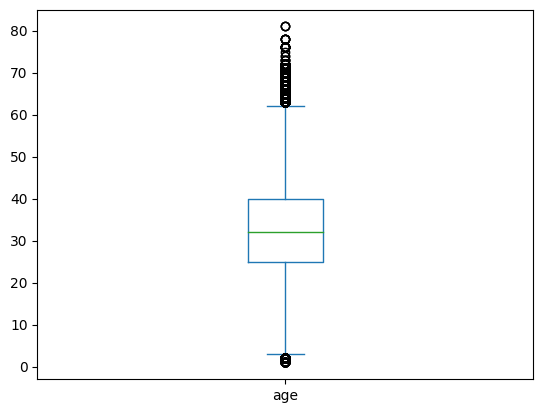

In [ ]:
condition["age"].plot(kind = "box");

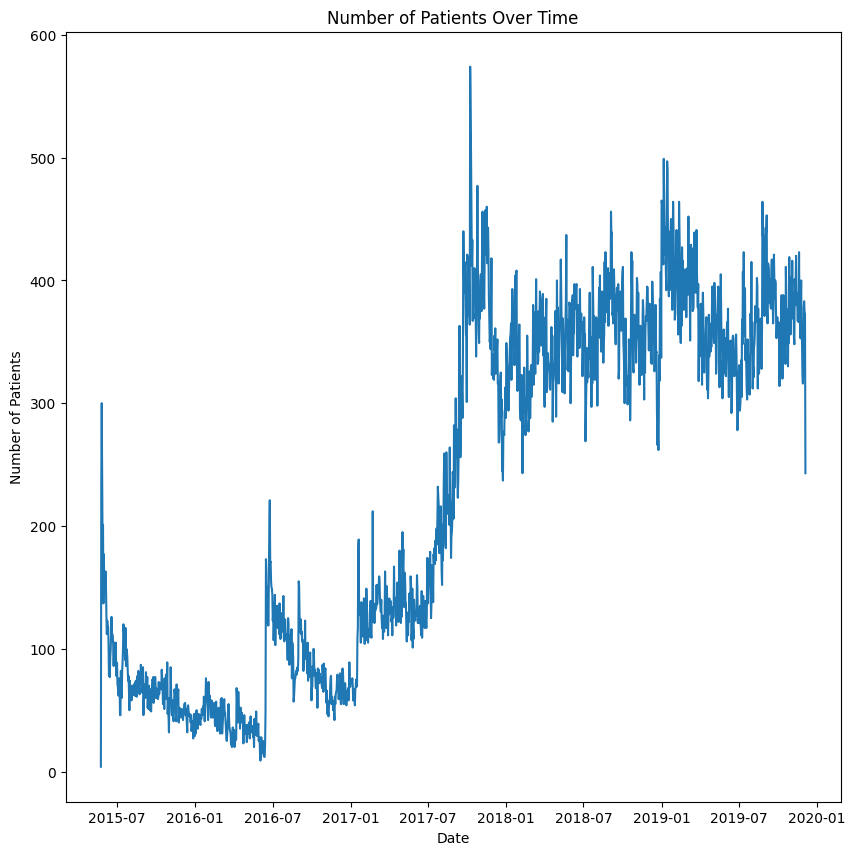

In [ ]:
count_data = condition.groupby('checkin_date').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x='checkin_date', y='count', data=count_data, ax=ax)
plt.xlabel("Date")
plt.ylabel("Number of Patients")
plt.title("Number of Patients Over Time")
plt.show()


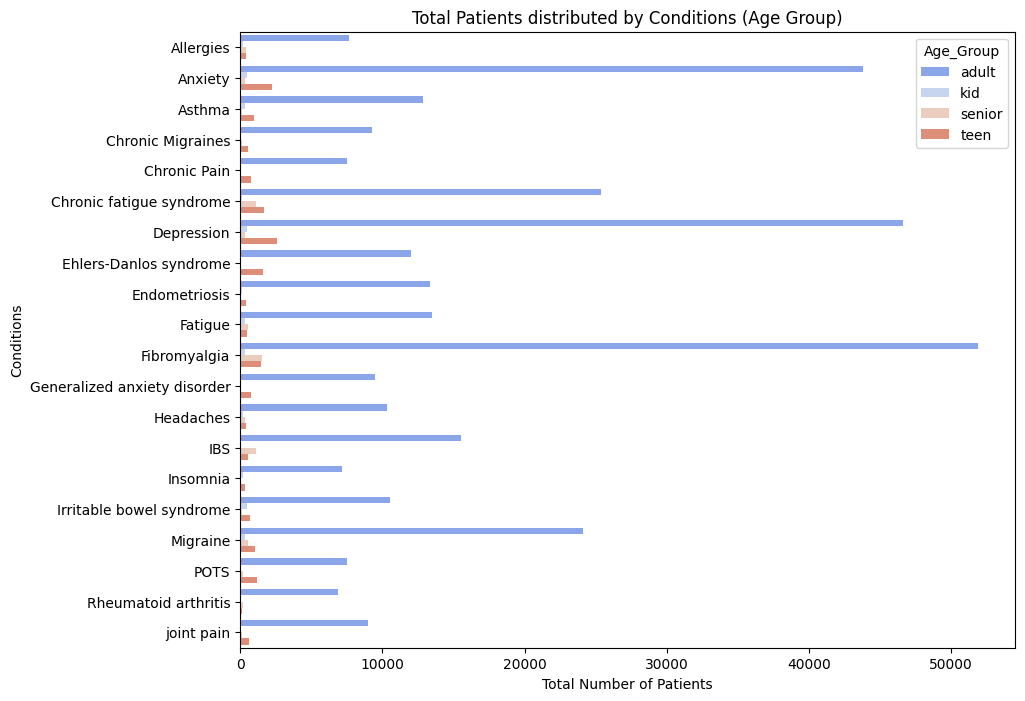

In [ ]:
t = condition.groupby(["trackable_name", "Age_Group"]).size()
t = t[t > 2].reset_index(name = "count")
plt.figure(figsize=(10, 8))
sns.barplot(data = t, x = "count", y = "trackable_name", hue = "Age_Group", orient = "h", palette = "coolwarm");
plt.xlabel("Total Number of Patients")
plt.ylabel("Conditions")
plt.title("Total Patients distributed by Conditions (Age Group)");

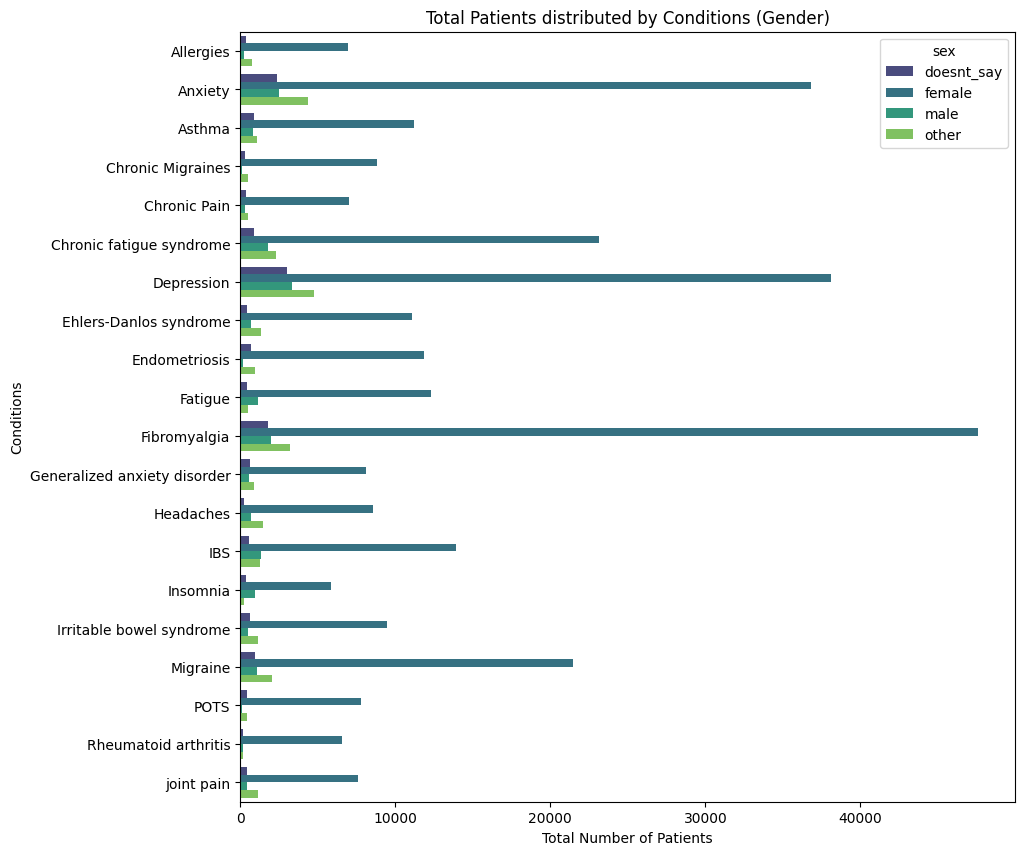

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
t = condition.groupby(["trackable_name", "sex"]).size()
t = t[t > 2].reset_index(name = "count")
sns.barplot(data = t, x = "count", y = "trackable_name", hue = "sex", palette = "viridis", ax =ax);
plt.xlabel("Total Number of Patients")
plt.ylabel("Conditions")
plt.title("Total Patients distributed by Conditions (Gender)");

In [ ]:
condition["trackable_value"] = condition["trackable_value"].astype(float)
condition["trackable_value"].value_counts(normalize = True)

trackable_value
2.0    0.257341
1.0    0.236339
0.0    0.195434
3.0    0.193971
4.0    0.116915
Name: proportion, dtype: float64

In [ ]:
import numpy as np

disease_pivot = pd.pivot_table(condition, index = "trackable_name", values = "trackable_value", aggfunc = np.mean).sort_values(by = "trackable_value")
disease_pivot = disease_pivot[disease_pivot > 1]
disease_pivot

trackable_value
trackable_name                               
Asthma                               1.010198
Migraine                             1.025307
Headaches                            1.367309
IBS                                  1.384726
Depression                           1.389219
Allergies                            1.428571
Irritable bowel syndrome             1.478858
Endometriosis                        1.502163
Chronic Migraines                    1.524230
Anxiety                              1.622982
Insomnia                             1.651677
Generalized anxiety disorder         1.791144
Rheumatoid arthritis                 2.006075
POTS                                 2.043148
joint pain                           2.141104
Fatigue                              2.186888
Ehlers-Danlos syndrome               2.410982
Fibromyalgia                         2.453586
Chronic Pain                         2.539271
Chronic fatigue syndrome             2.663338

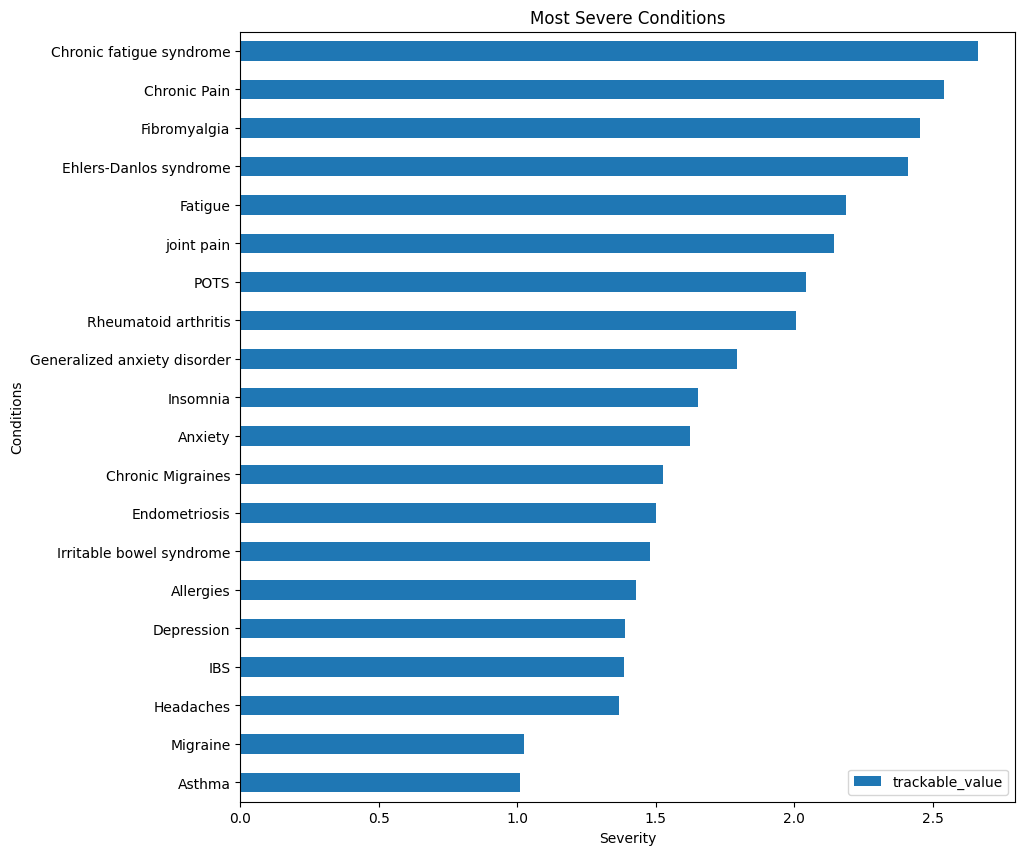

In [ ]:
disease_pivot.plot(kind = "barh", figsize = (10,10))
plt.xlabel("Severity")
plt.ylabel("Conditions")
plt.title("Most Severe Conditions");

In [ ]:
# @title Country Codes to Country
country_mapping = {
    'US': 'United States',
    'GB': 'United Kingdom',
    'AU': 'Australia',
    'CA': 'Canada',
    'unknown': 'Unknown',
    'DE': 'Germany',
    'NZ': 'New Zealand',
    'NL': 'Netherlands',
    'SE': 'Sweden',
    'FR': 'France',
    'ZA': 'South Africa',
    'NO': 'Norway',
    'FI': 'Finland',
    'BE': 'Belgium',
    'IE': 'Ireland',
    'CH': 'Switzerland',
    'DK': 'Denmark',
    'UM': 'United States Minor Outlying Islands',
    'IL': 'Israel',
    'AT': 'Austria',
    'UY': 'Uruguay',
    'GI': 'Gibraltar',
    'SG': 'Singapore',
    'ES': 'Spain',
    'AF': 'Afghanistan',
    'BR': 'Brazil',
    'MY': 'Malaysia',
    'TT': 'Trinidad and Tobago',
    'SI': 'Slovenia',
    'IS': 'Iceland',
    'JP': 'Japan',
    'IN': 'India',
    'MX': 'Mexico',
    'RU': 'Russia',
    'AR': 'Argentina',
    'PL': 'Poland',
    'PT': 'Portugal',
    'IT': 'Italy',
    'PE': 'Peru',
    'CZ': 'Czechia',
    'HK': 'Hong Kong',
    'DZ': 'Algeria',
    'MK': 'North Macedonia',
    'PK': 'Pakistan',
    'AE': 'United Arab Emirates',
    'JE': 'Jersey',
    'GR': 'Greece',
    'PR': 'Puerto Rico',
    'PH': 'Philippines',
    'RS': 'Serbia',
    'LB': 'Lebanon',
    'UA': 'Ukraine',
    'HR': 'Croatia',
    'AS': 'American Samoa',
    'CL': 'Chile',
    'GD': 'Grenada',
    'EE': 'Estonia',
    'SK': 'Slovakia',
    'CO': 'Colombia',
    'DO': 'Dominican Republic',
    'HU': 'Hungary',
    'RO': 'Romania',
    'KR': 'South Korea',
    'AQ': 'Antarctica',
    'ID': 'Indonesia',
    'VE': 'Venezuela',
    'LT': 'Lithuania',
    'TH': 'Thailand',
    'JM': 'Jamaica',
    'NG': 'Nigeria',
    'CN': 'China',
    'TR': 'Turkey',
    'IR': 'Iran',
    'LU': 'Luxembourg',
    'CR': 'Costa Rica',
    'AX': 'Åland Islands',
    'AL': 'Albania',
    'JO': 'Jordan',
    'SV': 'El Salvador',
    'SA': 'Saudi Arabia',
    'KH': 'Cambodia',
    'MU': 'Mauritius',
    'VI': 'Virgin Islands (U.S.)',
    'GT': 'Guatemala',
    'IM': 'Isle of Man',
    'VG': 'British Virgin Islands',
    'HN': 'Honduras',
    'EG': 'Egypt',
    'BG': 'Bulgaria',
    'NP': 'Nepal',
    'TW': 'Taiwan',
    'BH': 'Bahrain',
    'AG': 'Antigua and Barbuda',
    'LV': 'Latvia',
    'LR': 'Liberia',
    'PA': 'Panama',
    'BB': 'Barbados',
    'BD': 'Bangladesh',
    'FK': 'Falkland Islands',
    'AD': 'Andorra',
    'RE': 'Réunion',
    'NI': 'Nicaragua',
    'BM': 'Bermuda',
    'AW': 'Aruba',
    'ZW': 'Zimbabwe',
    'GG': 'Guernsey',
    'BZ': 'Belize',
    'CU': 'Cuba',
    'PG': 'Papua New Guinea',
    'QA': 'Qatar',
    'CV': 'Cape Verde',
    'KY': 'Cayman Islands',
    'PY': 'Paraguay',
    'ZM': 'Zambia',
    'FO': 'Faroe Islands',
    'KE': 'Kenya',
    'KW': 'Kuwait',
    'LC': 'Saint Lucia',
    'EC': 'Ecuador',
    'LK': 'Sri Lanka',
    'BQ': 'Bonaire, Sint Eustatius and Saba',
    'MA': 'Morocco',
    'BA': 'Bosnia and Herzegovina',
    'IO': 'British Indian Ocean Territory',
    'ST': 'Sao Tome and Principe',
    'SC': 'Seychelles',
    'MD': 'Moldova',
    'MT': 'Malta',
    'GP': 'Guadeloupe',
    'BS': 'The Bahamas',
    'SX': 'Sint Maarten',
    'BY': 'Belarus',
    'GY': 'Guyana',
    'GH': 'Ghana',
    'HT': 'Haiti',
    'PF': 'French Polynesia',
    'WS': 'Samoa',
    'MO': 'Macau',
    'TV': 'Tuvalu',
    'BN': 'Brunei',
    'GE': 'Georgia',
    'SZ': 'Eswatini',
    'BF': 'Burkina Faso',
    'YE': 'Yemen',
    'BW': 'Botswana',
    'MG': 'Madagascar',
    'VN': 'Vietnam',
    'TN': 'Tunisia',
    'BT': 'Bhutan',
    'TF': 'French Southern and Antarctic Lands',
    'ME': 'Montenegro',
    'TZ': 'Tanzania',
    'CI': 'Côte d\'Ivoire',
    'UG': 'Uganda',
    'SO': 'Somalia',
    'KZ': 'Kazakhstan',
    'UZ': 'Uzbekistan',
    'VU': 'Vanuatu',
    'SD': 'Sudan',
    'ET': 'Ethiopia',
    'LY': 'Libya',
    'LR': 'Liberia',
    'OM': 'Oman',
    'IQ': 'Iraq',
    'MV': 'Maldives'
}

In [ ]:


def choropleth_mapbox(df, country_mapping, geojson_path):
    country_mapp = pd.DataFrame(list(country_mapping.items()), columns=['country_code', 'country_name'])

    country_patients_count = df.groupby('country')['user_id'].nunique().reset_index(name='num_patients')

    condition_with_country_names = country_mapp.merge(country_patients_count, left_on='country_code', right_on='country', how='left')

    condition_with_country_names = condition_with_country_names.drop(columns=["country", "country_code"])

    gpd_df = gpd.read_file(geojson_path)

    world = pd.merge(gpd_df, condition_with_country_names, left_on='admin', right_on='country_name', how='left')

    fig = px.choropleth_mapbox(
        world,
        geojson=gpd_df.geometry.__geo_interface__,
        locations=world.index,
        color="num_patients",
        color_continuous_scale="rainbow",
        mapbox_style="carto-positron",
        center={"lat": 0, "lon": 0},
        zoom=2,
        opacity=0.5,
        labels={'num_patients': 'Number of Patients', 'top_diseases': "Top Disease"},
        title = "Countries with Most Patients"
    )

    fig.show()


In [ ]:
fig = choropleth_mapbox(condition, country_mapping, "/content/drive/MyDrive/DataSets for Colab/Disease Data /custom.geo.json")

##Data Preprocessing & Visualization - Weather

In [ ]:
def wrangle_weather(path):
    df = pd.read_csv(path)
    df = df[df["trackable_type"] ==  "Weather"]
    df = df.drop(["trackable_type"], axis = 1)
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    unique_trackable_name_counts = df["trackable_name"].value_counts()

    top_20_trackable_names = unique_trackable_name_counts.head(20).index

    df = df[df["trackable_name"].isin(top_20_trackable_names)]

    df = df.reset_index(drop=True)
    #df["age"] = df["age"].fillna(df["age"].mean())
    #df["age"] = df["age"].astype(int)

    def age_group(x):
        if x < 13:
            return "kid"
        elif x < 20:
            return "teen"
        elif x <= 60:
            return "adult"
        else:
            return "senior"

    df["Age_Group"] = df["age"].apply(age_group)

    df = df[df["age"] < 90]
    df = df[df["age"] > 0]
    return df

In [ ]:
weather = wrangle_weather(path)
weather.head()

user_id  age     sex country checkin_date  \
0  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
1  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
2  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
3  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
4  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   

  trackable_id    trackable_name trackable_value Age_Group  
0         9363              icon            rain       kid  
1         9363   temperature_min            54.0       kid  
2         9363   temperature_max            69.0       kid  
3         9363  precip_intensity          0.0031       kid  
4         9363          pressure          1012.0       kid

In [ ]:
weather.dropna(inplace=True)

In [ ]:
weather.isnull().sum()

user_id            0
age                0
sex                0
country            0
checkin_date       0
trackable_id       0
trackable_name     0
trackable_value    0
Age_Group          0
dtype: int64

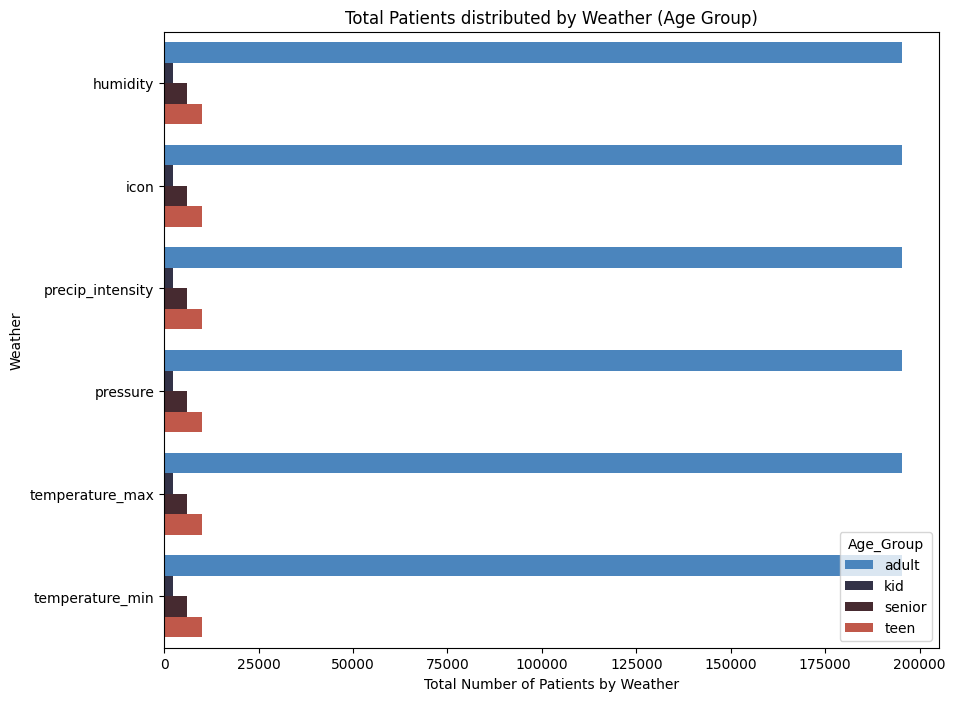

In [ ]:
t = weather.groupby(["trackable_name", "Age_Group"]).size()
t = t[t > 2].reset_index(name = "count")
plt.figure(figsize=(10, 8))
sns.barplot(data = t, x = "count", y = "trackable_name", hue = "Age_Group", orient = "h", palette = "icefire");
plt.xlabel("Total Number of Patients by Weather")
plt.ylabel("Weather")
plt.title("Total Patients distributed by Weather (Age Group)");

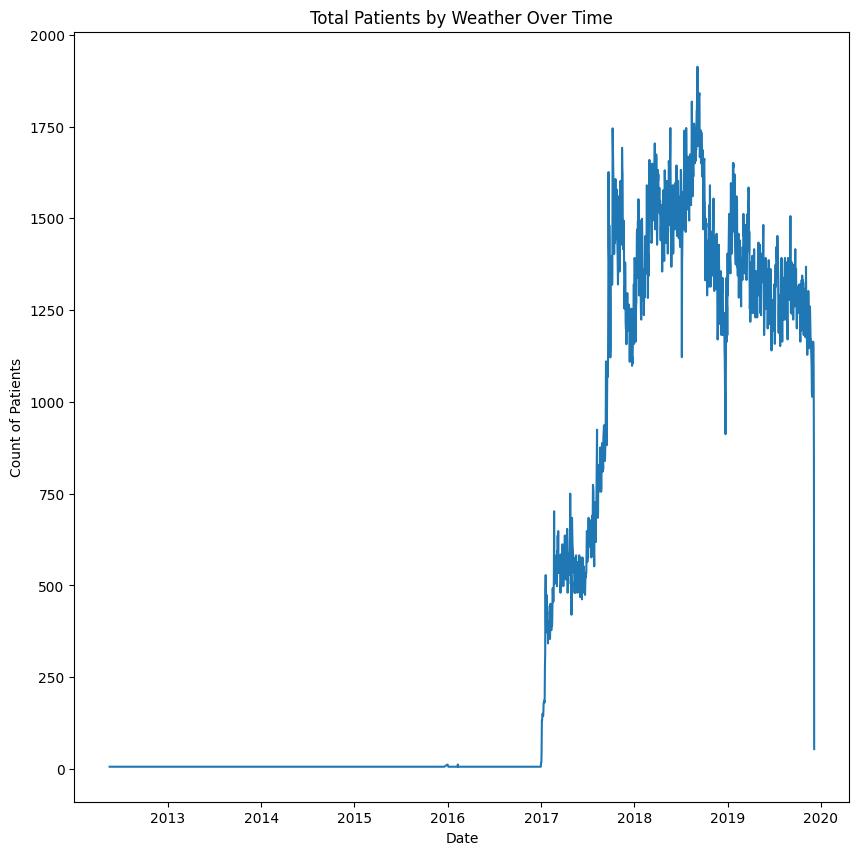

In [ ]:

count_data = weather.groupby("checkin_date").size().reset_index(name = "count")
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x="checkin_date", y="count", data=count_data, ax =ax)
plt.xlabel("Date")
plt.ylabel("Count of Patients")
plt.title("Total Patients by Weather Over Time");

In [ ]:
def choropleth_mapbox(df, country_mapping, geojson_path):
    country_mapp = pd.DataFrame(list(country_mapping.items()), columns=['country_code', 'country_name'])

    country_patients_count = df.groupby('country')['user_id'].nunique().reset_index(name='num_patients')

    condition_with_country_names = country_mapp.merge(country_patients_count, left_on='country_code', right_on='country', how='left')

    condition_with_country_names = condition_with_country_names.drop(columns=["country", "country_code"])

    gpd_df = gpd.read_file(geojson_path)

    world = pd.merge(gpd_df, condition_with_country_names, left_on='admin', right_on='country_name', how='left')

    fig = px.choropleth_mapbox(
        world,
        geojson=gpd_df.geometry.__geo_interface__,
        locations=world.index,
        color="num_patients",
        color_continuous_scale="Viridis",
        mapbox_style="carto-positron",
        center={"lat": 0, "lon": 0},
        zoom=2,
        opacity=0.5,
        labels={'num_patients': 'Number of Patients', 'top_diseases': "Top Disease"},
        title = "Countries Most Effected by Weather"
    )

    fig.show()

choropleth_mapbox(weather, country_mapping, "/content/drive/MyDrive/DataSets for Colab/Disease Data /custom.geo.json")

##Data Preprocessing & Visualization - Treatment

In [ ]:
def wrangle_treatment(path):
    df = pd.read_csv(path)
    df = df[df["trackable_type"] ==  "Treatment"]
    df = df.drop(["trackable_type"], axis = 1)
    df['checkin_date'] = pd.to_datetime(df['checkin_date'])
    unique_trackable_name_counts = df["trackable_name"].value_counts()

    top_20_trackable_names = unique_trackable_name_counts.head(20).index

    df = df[df["trackable_name"].isin(top_20_trackable_names)]

    df = df.reset_index(drop=True)
    #df["age"] = df["age"].fillna(df["age"].mean())
    #df["age"] = df["age"].astype(int)

    def age_group(x):
        if x < 13:
            return "kid"
        elif x < 20:
            return "teen"
        elif x <= 60:
            return "adult"
        else:
            return "senior"

    df["Age_Group"] = df["age"].apply(age_group)

    df = df[df["age"] < 90]
    df = df[df["age"] > 0]

    return df

In [ ]:
treatment = wrangle_treatment(path)

In [ ]:
treatment.shape

(164660, 9)

In [ ]:
treatment.head()

user_id   age     sex country checkin_date  \
0  QEVuQwEAookfJXqVy92WEQWogzQJRw==  31.0   other      US   2015-05-25   
1  QEVuQwEAdmwUDJyS5M+dwYUKpgyRLw==  33.0    male      US   2015-05-25   
2  QEVuQwEA5hkzTOaPksnHJZZjyHW/Ww==  50.0  female      US   2017-03-16   
4  QEVuQwEABHIqeasMvY8+o3YIhBXq9Q==  30.0  female      AU   2015-07-18   
5  QEVuQwEAls3goJ2eZ9lCTdLGUAE5Wg==  44.0    male      US   2019-04-13   

  trackable_id trackable_name trackable_value Age_Group  
0         4544      Ibuprofen        600.0 mg     adult  
1         4544      Ibuprofen        600.0 mg     adult  
2         2527       Cymbalta         60.0 mg     adult  
4         8105     Sertraline        100.0 mg     adult  
5         9213        Tylenol        200.0 mg     adult

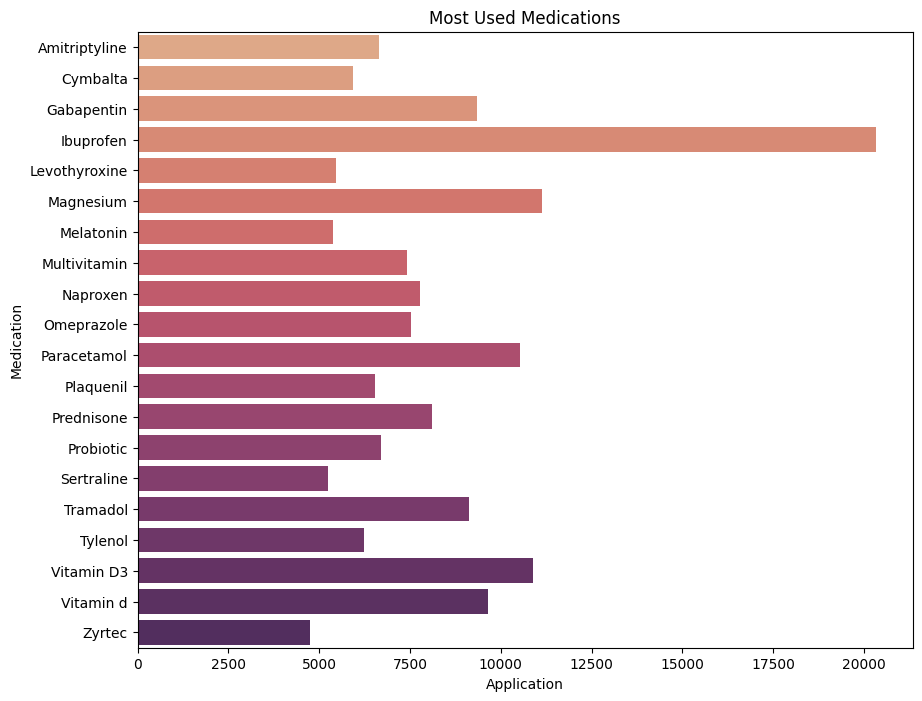

In [ ]:
t = treatment.groupby(["trackable_name"]).size()
t = t[t > 2].reset_index(name = "count")
plt.figure(figsize=(10, 8))
sns.barplot(data = t, x = "count", y = "trackable_name", orient = "h", palette = "flare");
plt.xlabel("Application")
plt.ylabel("Medication")
plt.title("Most Used Medications");

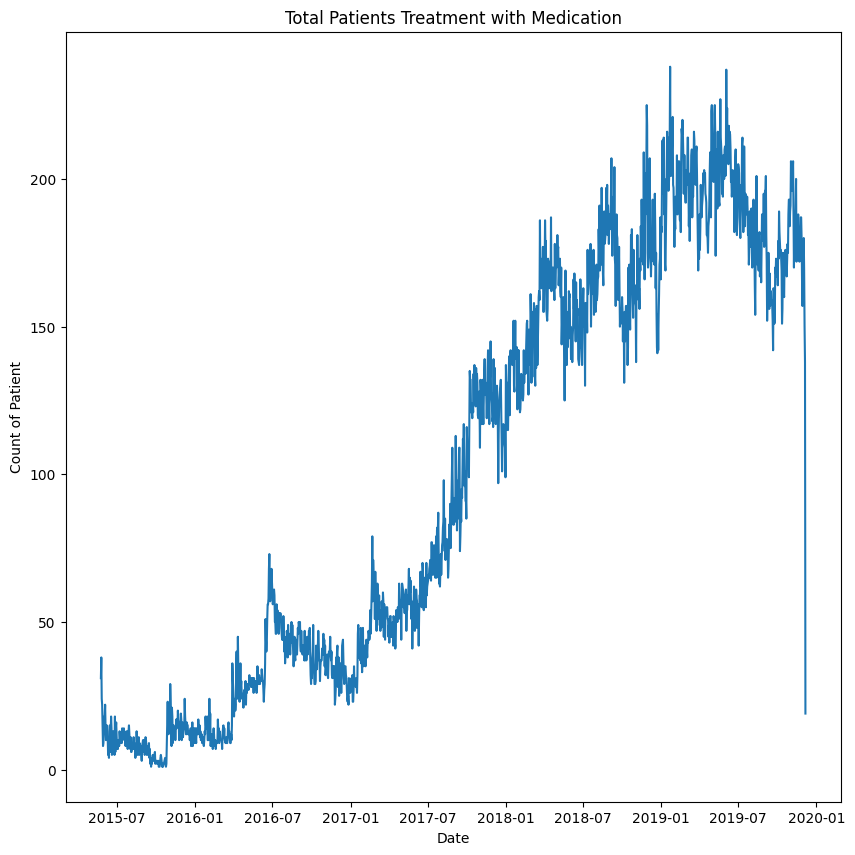

In [ ]:
count_data = treatment.groupby("checkin_date").size().reset_index(name = "count")
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x="checkin_date", y="count", data=count_data, ax =ax)
plt.xlabel("Date")
plt.ylabel("Count of Patient")
plt.title("Total Patients Treatment with Medication");

##Predicting Patients affected by Conditions

In [ ]:
condition.drop(columns = ["user_id", "trackable_id", "checkin_date", "age", "sex", "country"], inplace = True)

In [ ]:
# @title Base ML Code {"form-width":"10px"}
def logisticregression(df):
    target_columns = "trackable_value"
    features = df.drop(columns=target_columns)

    X = features
    y = df[target_columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("X_train shape is:", X_train.shape)
    print("X_test shape is:", X_test.shape)
    print("y_train shape is:", y_train.shape)
    print("y_test shape is:", y_test.shape)

    model = make_pipeline(
        OneHotEncoder(sparse=False, handle_unknown='ignore'),
        SimpleImputer(),
        LogisticRegression(random_state=16)
    )

    fitted_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy Score of Logistic Regression:", model.score(X_test, y_test))
    print("Baseline Logistic Regression Score is:", round(y_train.value_counts(normalize=True).max(), 4))
    print("Logistic Regression Precision Score:", round(precision_score(y_test, y_pred, average="macro"), 3))
    print("Logistic Regression F1 Score:", round(f1_score(y_test, y_pred, average="macro"), 3))
    print("Logistic Regression Recall Score:", round(recall_score(y_test, y_pred, average="macro"), 3))

    cnf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cnf_matrix, annot=True, fmt='g')
    plt.show()

    y_pred_proba = fitted_model.predict_proba(X_test)

    features = model.named_steps["onehotencoder"].get_feature_names_out()
    importances = model.named_steps["logisticregression"].coef_[0]

    odd_ratios = pd.DataFrame(np.exp(importances), index=features, columns=["Odds Ratio"])

    odd_ratios.head().plot(kind="barh", figsize=(10, 10))
    plt.show()

    odd_ratios.tail().plot(kind="barh", figsize=(10, 10))
    plt.show()

    return fitted_model

In [ ]:
def model_comparison(df):
    target_column = "trackable_value"
    features = df.drop(columns=target_column)

    X = features
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("X_train shape is:", X_train.shape)
    print("X_test shape is:", X_test.shape)
    print("y_train shape is:", y_train.shape)
    print("y_test shape is:", y_test.shape)

    # Pipelines
    models = {
        'LogisticRegression': make_pipeline(
            OneHotEncoder(sparse=False, handle_unknown='ignore'),
            SimpleImputer(),
            LogisticRegression(random_state=16)
        ),
        'DecisionTree': make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(strategy='most_frequent'),
            DecisionTreeClassifier(random_state=16)
        ),
        'XGBoost': make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(strategy='most_frequent'),
            XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=16)
        )
    }

    fitted_models = {}
    performance_metrics = []

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model.fit(X_train, y_train)
        fitted_models[name] = model

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="macro")
        recall = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")

        print(f"Accuracy Score of {name}:", accuracy)
        print(f"Precision Score of {name}:", precision)
        print(f"Recall Score of {name}:", recall)
        print(f"F1 Score of {name}:", f1)
        print(f"Confusion Matrix of {name}:\n", confusion_matrix(y_test, y_pred))
        print(f"Classification Report of {name}:\n", classification_report(y_test, y_pred))

        # Performance metrics
        performance_metrics.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        if name == 'LogisticRegression':
            # Plot for Logistic Regression
            features = model.named_steps["onehotencoder"].get_feature_names_out()
            importances = model.named_steps["logisticregression"].coef_[0]
            odd_ratios = pd.DataFrame(np.exp(importances), index=features, columns=["Odds Ratio"])
            odd_ratios.head().plot(kind="barh", figsize=(10, 10), title=f"{name} Top Odds Ratios")
            plt.show()
            odd_ratios.tail().plot(kind="barh", figsize=(10, 10), title=f"{name} Bottom Odds Ratios")
            plt.show()

        if name == 'DecisionTree':
            # Plotting Decision Tree
            plt.figure(figsize=(20, 10))
            plot_tree(
                model.named_steps["decisiontreeclassifier"],
                feature_names=X_train.columns,
                filled=True,
                rounded=True,
                fontsize=10,
                max_depth=3
            )
            plt.title(f"Decision Tree Plot for {name}")
            plt.show()

        if name == 'XGBoost':
            # Plotting feature importance for XGBoost
            plt.figure(figsize=(10, 10))
            plot_importance(model.named_steps["xgbclassifier"])
            plt.title(f"Feature Importance for {name}")
            plt.show()

    performance_df = pd.DataFrame(performance_metrics)

    performance_pivot = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 8))
    bar_plot = performance_pivot.pivot_table(index='Metric', columns='Model', values='Score').plot(kind='bar')
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    return performance_df

X_train shape is: (299854, 2)
X_test shape is: (74964, 2)
y_train shape is: (299854,)
y_test shape is: (74964,)

Training LogisticRegression model...
Accuracy Score of LogisticRegression: 0.33010511712288565
Precision Score of LogisticRegression: 0.35267331936622615
Recall Score of LogisticRegression: 0.29896818593697405
F1 Score of LogisticRegression: 0.2818254921638478
Confusion Matrix of LogisticRegression:
 [[6825 6652 1045  207   59]
 [4202 8583 3744  978   82]
 [3471 6922 6456 2235  109]
 [2027 4265 5633 2616  111]
 [1145 2223 3292 1816  266]]
Classification Report of LogisticRegression:
               precision    recall  f1-score   support

         0.0       0.39      0.46      0.42     14788
         1.0       0.30      0.49      0.37     17589
         2.0       0.32      0.34      0.33     19193
         3.0       0.33      0.18      0.23     14652
         4.0       0.42      0.03      0.06      8742

    accuracy                           0.33     74964
   macro avg      

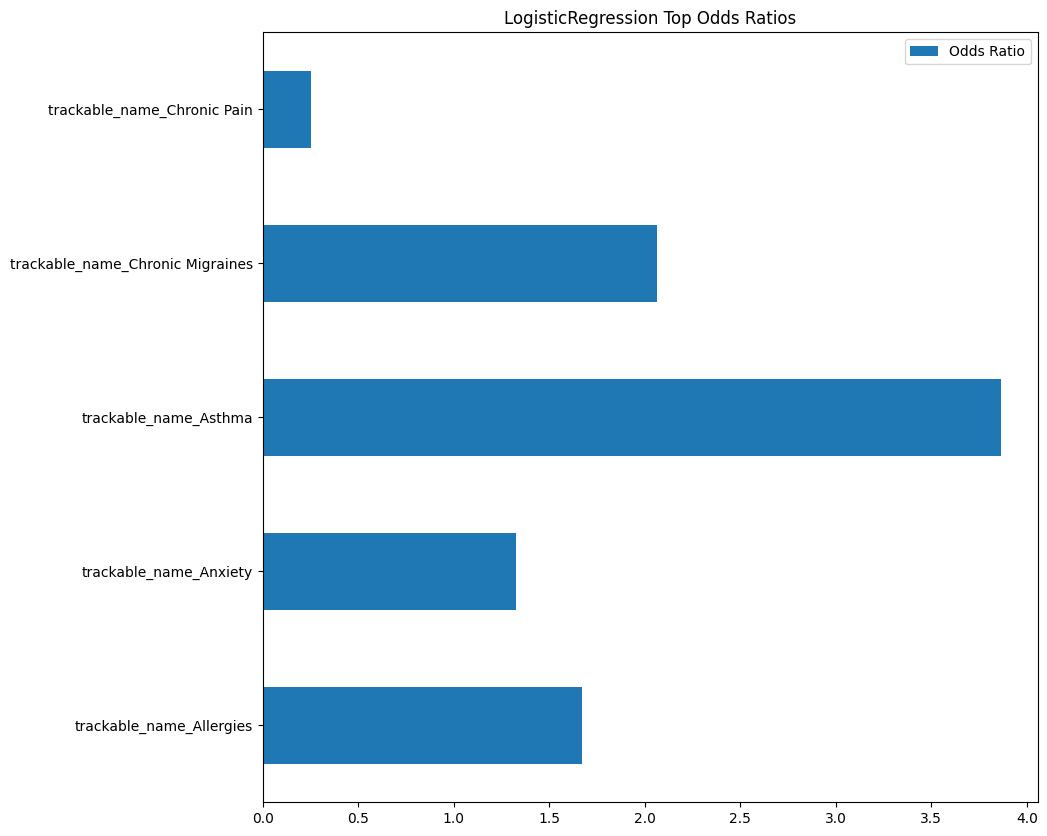

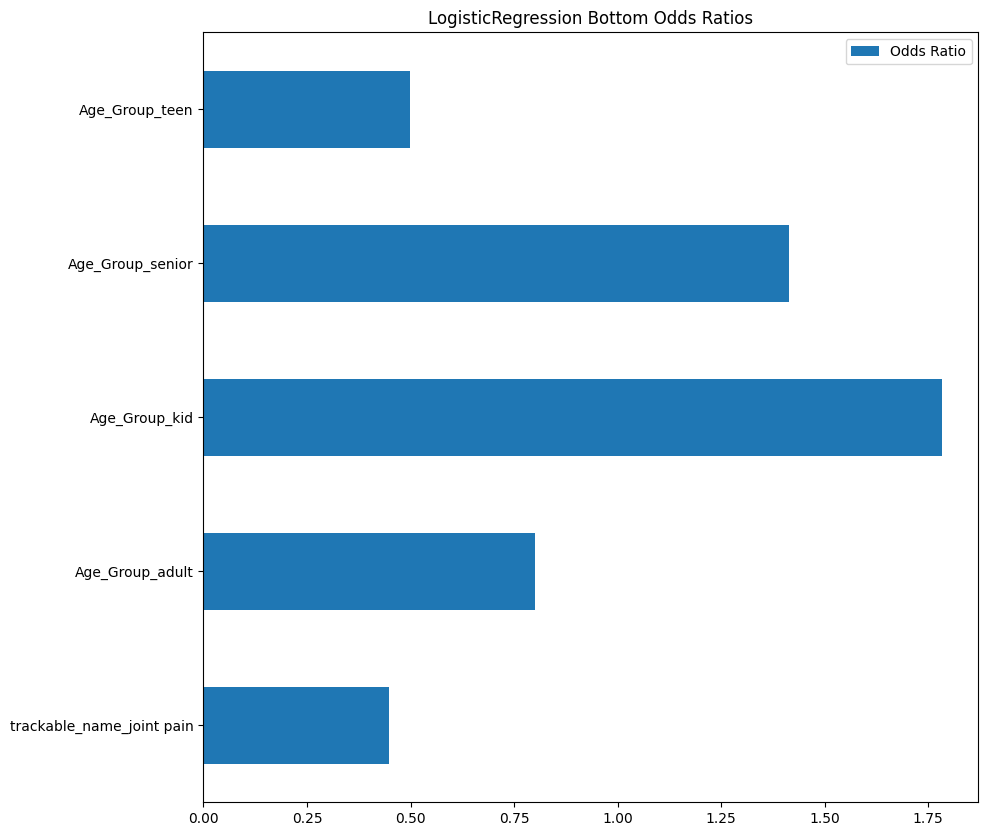


Training DecisionTree model...
Accuracy Score of DecisionTree: 0.33170588549170266
Precision Score of DecisionTree: 0.4067196428842495
Recall Score of DecisionTree: 0.29941678272757544
F1 Score of DecisionTree: 0.28098873345667197
Confusion Matrix of DecisionTree:
 [[6749 6703 1088  243    5]
 [4118 8657 3791 1007   16]
 [3370 6957 6575 2267   24]
 [1993 4264 5663 2689   43]
 [1115 2240 3294 1897  196]]
Classification Report of DecisionTree:
               precision    recall  f1-score   support

         0.0       0.39      0.46      0.42     14788
         1.0       0.30      0.49      0.37     17589
         2.0       0.32      0.34      0.33     19193
         3.0       0.33      0.18      0.24     14652
         4.0       0.69      0.02      0.04      8742

    accuracy                           0.33     74964
   macro avg       0.41      0.30      0.28     74964
weighted avg       0.38      0.33      0.31     74964



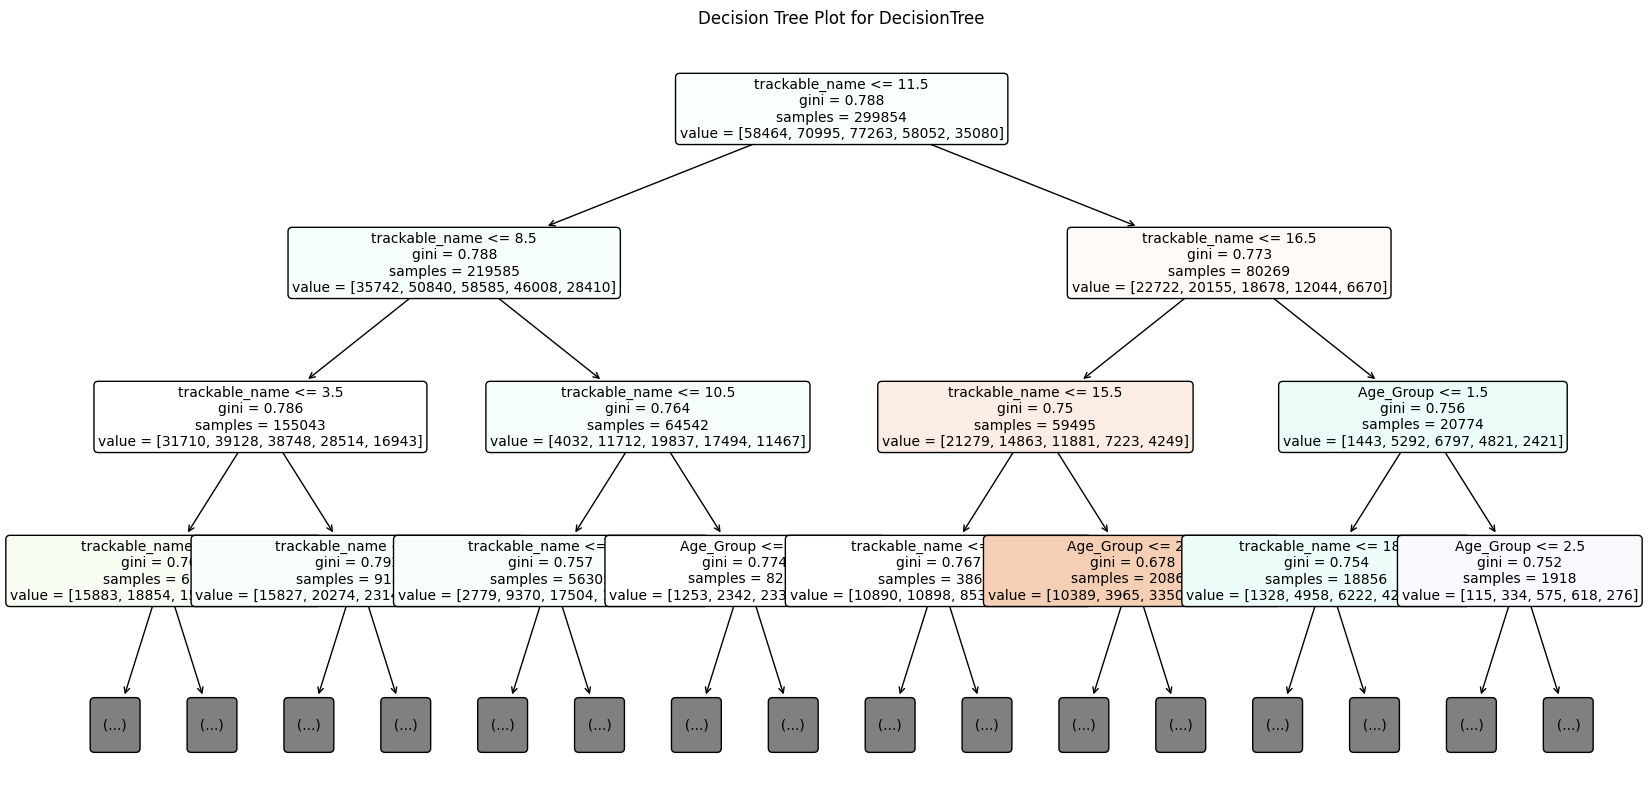


Training XGBoost model...
Accuracy Score of XGBoost: 0.33170588549170266
Precision Score of XGBoost: 0.4067196428842495
Recall Score of XGBoost: 0.29941678272757544
F1 Score of XGBoost: 0.28098873345667197
Confusion Matrix of XGBoost:
 [[6749 6703 1088  243    5]
 [4118 8657 3791 1007   16]
 [3370 6957 6575 2267   24]
 [1993 4264 5663 2689   43]
 [1115 2240 3294 1897  196]]
Classification Report of XGBoost:
               precision    recall  f1-score   support

         0.0       0.39      0.46      0.42     14788
         1.0       0.30      0.49      0.37     17589
         2.0       0.32      0.34      0.33     19193
         3.0       0.33      0.18      0.24     14652
         4.0       0.69      0.02      0.04      8742

    accuracy                           0.33     74964
   macro avg       0.41      0.30      0.28     74964
weighted avg       0.38      0.33      0.31     74964



<Figure size 1000x1000 with 0 Axes>

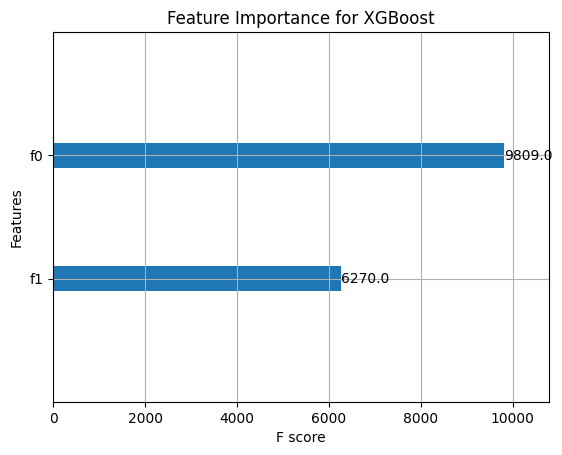

<Figure size 1200x800 with 0 Axes>

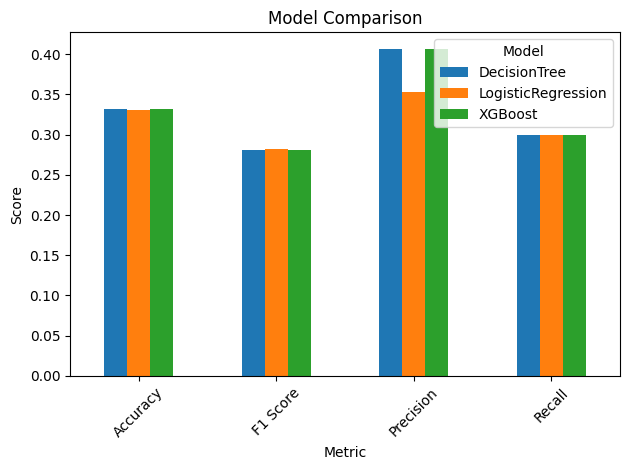

Model  Accuracy  Precision    Recall  F1 Score
0  LogisticRegression  0.330105   0.352673  0.298968  0.281825
1        DecisionTree  0.331706   0.406720  0.299417  0.280989
2             XGBoost  0.331706   0.406720  0.299417  0.280989

In [ ]:
model_comparison(condition)

The results from the Logistic Regression, Decision Tree, and XGBoost models show an overall accuracy of around 33%, with precision and recall scores also relatively low. While Decision Tree and XGBoost slightly improved precision compared to Logistic Regression, all models struggled to generalize well on the test data. The low F1 scores and confusion matrices suggest that the models had difficulty distinguishing between the different classes, possibly due to noisy data or class imbalance. Despite using more advanced models, the dataset's limited features and complexity appear to prevent any substantial improvements in performance.

##Predicting Patients Treated

In [ ]:
def model_comparison_treatment(df):
    target_column = "trackable_value"
    features = df.drop(columns=target_column)

    features = features.astype(str)

    X = features
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("X_train shape is:", X_train.shape)
    print("X_test shape is:", X_test.shape)
    print("y_train shape is:", y_train.shape)
    print("y_test shape is:", y_test.shape)

    models = {
        'RandomForest': make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(strategy='most_frequent'),
            RandomForestClassifier(random_state=16, n_jobs=-1, n_estimators=50, max_depth=10)
        )
    }

    fitted_models = {}
    performance_metrics = []

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model.fit(X_train, y_train)
        fitted_models[name] = model

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="macro")
        recall = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")

        print(f"Accuracy Score of {name}:", accuracy)
        print(f"Precision Score of {name}:", precision)
        print(f"Recall Score of {name}:", recall)
        print(f"F1 Score of {name}:", f1)
        print(f"Confusion Matrix of {name}:\n", confusion_matrix(y_test, y_pred))
        print(f"Classification Report of {name}:\n", classification_report(y_test, y_pred))

        performance_metrics.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        if name == 'RandomForest':
            importances = model.named_steps["randomforestclassifier"].feature_importances_
            features = X_train.columns
            forest_importances = pd.Series(importances, index=features)

            plt.figure(figsize=(10, 10))
            forest_importances.nlargest(10).plot(kind='barh', title=f"Top 10 Feature Importances for {name}")
            plt.show()

    performance_df = pd.DataFrame(performance_metrics)
    pivot_table = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 8))

    bar_plot = pivot_table.pivot(index="Metric", columns="Model", values="Score").plot(kind='bar')
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    return performance_df


In [ ]:
treatment = wrangle_treatment(path)

In [ ]:
treatment.drop(columns = ["user_id", "trackable_id", "checkin_date", "sex","age","country"], inplace = True)


X_train shape is: (131728, 2)
X_test shape is: (32932, 2)
y_train shape is: (131728,)
y_test shape is: (32932,)

Training RandomForest model...
Accuracy Score of RandomForest: 0.1595105064982388
Precision Score of RandomForest: 0.01650328230854621
Recall Score of RandomForest: 0.018193343282338157
F1 Score of RandomForest: 0.011152392062346665
Confusion Matrix of RandomForest:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report of RandomForest:
                                                                                   precision    recall  f1-score   support

                                                                           12 hr       0.00      0.00      0.00         1
                                                                       1x4000 IU       0.00      0.00      0.00        27
                                                                     (1) 50mg x4       0.00 

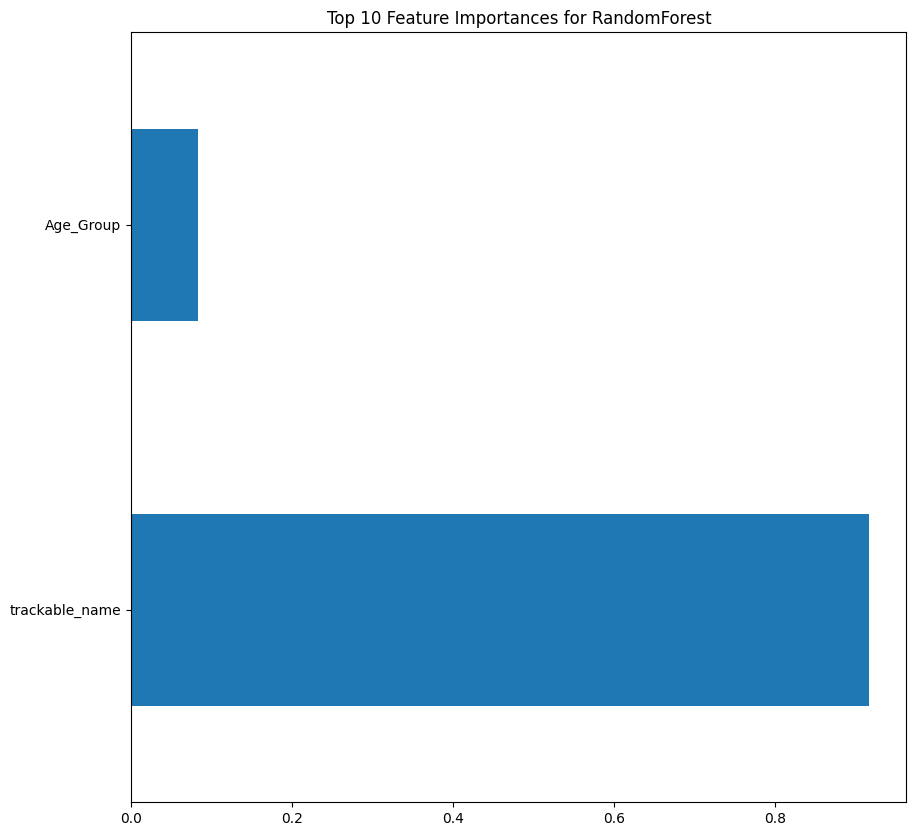

<Figure size 1200x800 with 0 Axes>

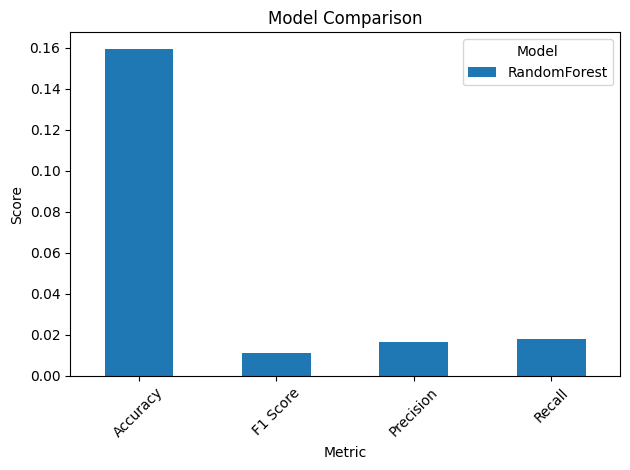

Model  Accuracy  Precision    Recall  F1 Score
0  RandomForest  0.159511   0.016503  0.018193  0.011152

In [ ]:
model_comparison_treatment(treatment)

The RandomForest model has performed poorly with an accuracy of 16%, precision of 1.65%, recall of 1.82%, and an F1 score of 1.12%, indicating it struggles to correctly predict positive cases and balance precision and recall effectively. The confusion matrix reveals that the model is predominantly predicting all instances as zero, with no correct predictions across other classes. This suggests issues such as class imbalance, inadequate feature representation, or model configuration problems. To improve performance, consider checking data quality, enhancing feature engineering, addressing class imbalance, tuning model hyperparameters, exploring alternative algorithms, and performing a detailed error analysis.

##Predicting Patients affected by Weather

In [ ]:
from sklearn.utils import resample

def model_comparison_weather(df, resample_size=None):
    target_column = "trackable_value"
    features = df.drop(columns=target_column)

    X = features
    y = df[target_column]

    # Resampling step (downsample or upsample)
    if resample_size:
        X_resampled, y_resampled = resample(X, y, n_samples=resample_size, random_state=42)
    else:
        X_resampled, y_resampled = X, y

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    print("X_train shape is:", X_train.shape)
    print("X_test shape is:", X_test.shape)
    print("y_train shape is:", y_train.shape)
    print("y_test shape is:", y_test.shape)

    # Pipelines
    models = {
        'RandomForest': make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(strategy='most_frequent'),
            RandomForestClassifier(random_state=16)
        )
    }

    fitted_models = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        model.fit(X_train, y_train)
        fitted_models[name] = model

        y_pred = model.predict(X_test)

        print(f"Accuracy Score of {name}:", accuracy_score(y_test, y_pred))
        print(f"Precision Score of {name}:", precision_score(y_test, y_pred, average="macro"))
        print(f"Recall Score of {name}:", recall_score(y_test, y_pred, average="macro"))
        print(f"F1 Score of {name}:", f1_score(y_test, y_pred, average="macro"))

        if name == 'RandomForest':
            # Plot feature importance for Random Forest
            importances = model.named_steps["randomforestclassifier"].feature_importances_
            features = X_train.columns
            forest_importances = pd.Series(importances, index=features)

            plt.figure(figsize=(10, 10))
            forest_importances.nlargest(10).plot(kind='barh', title=f"Top 10 Feature Importances for {name}")
            plt.show()

    return fitted_models


In [ ]:
weather = wrangle_weather(path)

In [ ]:
weather.head()

user_id  age     sex country checkin_date  \
0  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
1  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
2  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
3  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   
4  QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==  2.0  female      CA   2017-04-28   

  trackable_id    trackable_name trackable_value Age_Group  
0         9363              icon            rain       kid  
1         9363   temperature_min            54.0       kid  
2         9363   temperature_max            69.0       kid  
3         9363  precip_intensity          0.0031       kid  
4         9363          pressure          1012.0       kid

In [ ]:
weather.drop(columns = ["user_id", "trackable_id", "checkin_date", "sex","age","country"], inplace = True)
weather.dropna(inplace = True)

X_train shape is: (1064097, 2)
X_test shape is: (266025, 2)
y_train shape is: (1064097,)
y_test shape is: (266025,)

Training RandomForest model...
Accuracy Score of RandomForest: 0.12016915703411334
Precision Score of RandomForest: 0.0010038678339720141
Recall Score of RandomForest: 0.004188363470703558
F1 Score of RandomForest: 0.0012847613108047426


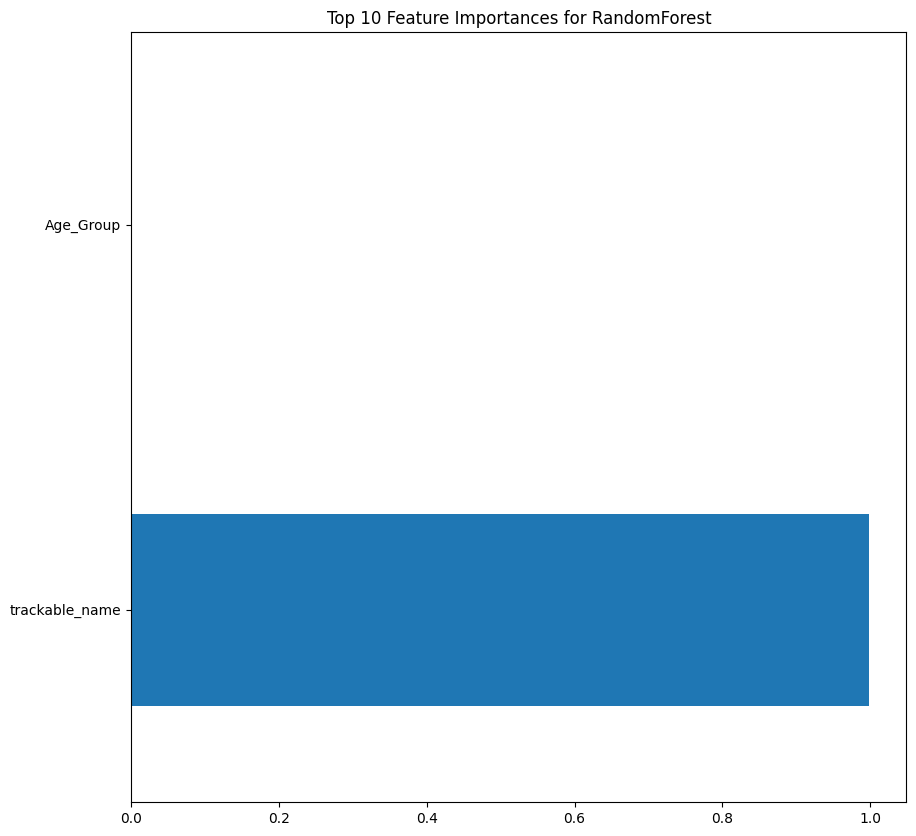

{'RandomForest': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('randomforestclassifier',
                  RandomForestClassifier(random_state=16))])}

In [ ]:
model_comparison_weather(weather)

The RandomForest model’s performance metrics reveal several key insights. The accuracy score of approximately 0.12 indicates that the model correctly predicts the outcome only 12% of the time, which suggests a significant challenge in making accurate predictions. The precision score, which is around 0.001, implies that when the model predicts a positive outcome, it is correct only 0.1% of the time, highlighting that it struggles with correctly identifying positive cases. The recall score of approximately 0.004 suggests that the model is able to identify only 0.4% of the actual positive cases, reflecting poor sensitivity. The F1 score, which is about 0.001, represents a weighted average of precision and recall and is very low, indicating that the model performs poorly in balancing both precision and recall. These metrics collectively indicate that the RandomForest model is currently not effective at predicting the target variable, possibly due to issues such as class imbalance, insufficient feature representation, or other model limitations.

##Ongoing Framework: Interactive App Development
A major extension of this project is the development of an interactive app that predicts diseases based on symptoms and provides treatment recommendations. The app utilizes the same dataset but focuses on symptoms as inputs to provide:

Disease prediction: Based on selected symptoms, the app predicts the most likely diseases.
Treatment suggestions: Offers suggested treatments and precautions for the predicted diseases.
This framework is still under development, with the goal of deploying a user-friendly interface that assists users in identifying possible health conditions and relevant treatments.

In [ ]:
# @title Interactive App Development
symptoms_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /DiseaseAndSymptoms.csv')
precautions_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /Disease precaution.csv')

combined_df = pd.merge(symptoms_df, precautions_df, on='Disease')

symptom_columns = ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', "Symptom_6", "Symptom_7", "Precaution_1","Precaution_2", "Precaution_3", "Precaution_4" ]  # Update with actual column names
X = combined_df[symptom_columns]
y = combined_df['Disease']

label_encoders = {}

for column in symptom_columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

y_le = LabelEncoder()
y = y_le.fit_transform(y)
label_encoders['Disease'] = y_le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Model evaluation for Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions, target_names=y_le.classes_)

print("Random Forest Model")
print(f'Accuracy: {rf_accuracy:.4f}')
print("Confusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)

# Visualization for Random Forest
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_le.classes_, yticklabels=y_le.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [symptom_columns[i] for i in indices], rotation=90)
plt.title('Feature Importances - Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Model evaluation for Logistic Regression
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)
logistic_class_report = classification_report(y_test, logistic_predictions, target_names=y_le.classes_)

print("Logistic Regression Model")
print(f'Accuracy: {logistic_accuracy:.4f}')
print("Confusion Matrix:")
print(logistic_conf_matrix)
print("\nClassification Report:")
print(logistic_class_report)

# Visualization for Logistic Regression
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(logistic_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_le.classes_, yticklabels=y_le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve (For Binary Classification - Update for Multiclass if needed)
if len(y_le.classes_) == 2:
    y_test_bin = label_binarize(y_test, classes=y_le.classes_)
    y_score = logistic_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Save the models and label encoders
joblib.dump(rf_model, 'TrainedRandomForrest.pkl')
joblib.dump(logistic_model, 'TrainedLogisticModel.pkl')
joblib.dump(label_encoders, 'LabelEncoders.pkl')


In [ ]:
# @title
import os

# Create the templates directory
os.makedirs('templates', exist_ok=True)

In [ ]:
# @title HTML - Index.html
# Create index.html
%%writefile templates/index.html
<!DOCTYPE html>
<html>
<head>
    <title>Disease Prediction</title>
</head>
<body>
    <h1>Disease Prediction</h1>
    <form method="POST">
        <label for="symptom_1">Symptom 1:</label>
        <input type="text" id="symptom_1" name="symptom_1"><br>

        <label for="symptom_2">Symptom 2:</label>
        <input type="text" id="symptom_2" name="symptom_2"><br>

        <label for="symptom_3">Symptom 3:</label>
        <input type="text" id="symptom_3" name="symptom_3"><br>

        <label for="symptom_4">Symptom 4:</label>
        <input type="text" id="symptom_4" name="symptom_4"><br>

        <label for="symptom_5">Symptom 5:</label>
        <input type="text" id="symptom_5" name="symptom_5"><br>

        <input type="submit" value="Predict">
    </form>
</body>
</html>


In [ ]:
# @title HTML - result.html
# Create result.html
%%writefile templates/result.html
<!DOCTYPE html>
<html>
<head>
    <title>Prediction Result</title>
</head>
<body>
    <h1>Prediction Result</h1>
    <p><strong>Disease:</strong> {{ disease }}</p>
    <p><strong>Precaution:</strong> {{ precaution }}</p>
    <a href="/">Go Back</a>
</body>
</html>


In [ ]:
# @title Flask FrameWork
app = Flask(__name__)
model = joblib.load('TrainedRandomForrest.pkl')
precautions_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /Disease precaution.csv')
symptoms_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /DiseaseAndSymptoms.csv')

# Load label encoders
label_encoders = joblib.load('LabelEncoders.pkl')
symptom_columns = [col for col in symptoms_df.columns if 'Symptom' in col]

@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        symptoms = [request.form.get('Symptom_1'), request.form.get('Symptom_2'), request.form.get('symptom_3'),
                    request.form.get('Symptom_4'), request.form.get('Symptom_5')]

        # Encode symptoms
        symptoms_encoded = [label_encoders[column].transform([symptoms[i]])[0] if symptoms[i] else 0 for i, column in enumerate(symptom_columns)]
        prediction = model.predict([symptoms_encoded])

        disease = y_le.inverse_transform(prediction)[0]
        precaution = precautions_df[precautions_df['Disease'] == disease]['Precaution'].values[0]

        return render_template('result.html', disease=disease, precaution=precaution)

    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
# @title Streamlit FrameWork
model = joblib.load('TrainedLogisticModel.pkl')
precautions_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /Disease precaution.csv')
symptoms_df = pd.read_csv('/content/drive/MyDrive/DataSets for Colab/Disease Data /DiseaseAndSymptoms.csv')

# Load label encoders
label_encoders = joblib.load('LabelEncoders.pkl')
symptom_columns = [col for col in symptoms_df.columns if 'Symptom' in col]

st.title('Symptom to Precaution Predictor')

# Input fields
symptom_1 = st.text_input('itching:')
symptom_2 = st.text_input('skin_rash:')
symptom_3 = st.text_input('nodal_skin_eruptions:')
symptom_4 = st.text_input('dischromic _patches:')
symptom_5 = st.text_input(':')

if st.button('Predict'):
    # Prepare input data
    symptoms = [symptom_1, symptom_2, symptom_3, symptom_4, symptom_5]
    symptoms_encoded = [label_encoders[column].transform([symptoms[i]])[0] if symptoms[i] else 0 for i, column in enumerate(symptom_columns)]

    # Make prediction
    prediction = model.predict([symptoms_encoded])

    # Retrieve and display precaution
    disease = y_le.inverse_transform(prediction)[0]
    precaution = precautions_df[precautions_df['Disease'] == disease]['Precaution'].values[0]

    st.write(f'Disease: {disease}')
    st.write(f'Precaution: {precaution}')


In [ ]:
# @title Launcher
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py

##Challenges & Learnings

Feature Importance Analysis: Weather factors like temperature and humidity had some influence, but patient-specific variables such as age and pre-existing conditions played a bigger role.
Complexity of real-world data: The dataset was noisy, with many confounding factors making it difficult to achieve high accuracy.
Interactive App Development: Building a robust system to handle multiple symptom inputs and provide reliable predictions remains a challenging task, but progress is being made.

##Conclusion
This project demonstrated the challenges of working with real-world medical and environmental datasets. While the machine learning models did not perform at the desired level, the project offered valuable insights into the relationships between weather conditions and patient health.

The ongoing development of an interactive app will extend this work by offering practical, symptom-based disease prediction and treatment recommendations to users.